Universidade Federal de Santa Catarina<br>
Departamento de Engenharia Elétrica e Eletrônica<br>
EEL7514/EEL7513/EEL410250 - Aprendizado de Máquina
$\newcommand{\bX}{\mathbf{X}}$
$\newcommand{\bw}{\mathbf{w}}$
$\newcommand{\by}{\mathbf{y}}$
$\newcommand{\bx}{\mathbf{x}}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\bzero}{\mathbf{0}}$


# Exercício 3: Regressão Linear & Otimização Numérica

Neste exercício você irá explorar métodos de otimização numérica para treinar um modelo de regressão linear. Em particular, você irá implementar o método do gradiente e analisar sua convergência. Além disso, você irá investigar o efeito da normalização de atributos no comportamento do método. Finalmente, você irá investigar a aplicação de regressão linear em um conjunto de dados real.

# Conjunto de dados #1

Inicialmente, utilizaremos o mesmo conjunto de dados do exercício anterior, exceto por uma escala diferente em $x$.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

def gen_data(n_samples, x_scale=[0,1], noise=0.5):
    '''Generate univariate regression dataset'''
    x = np.sort(np.random.rand(n_samples))
    y = 6*(-1/6 + x + (x > 1/3)*(2/3-2*x) + (x > 2/3)*(2*x-4/3)) + noise*np.random.randn(n_samples)
    x = x_scale[0] + (x_scale[1]-x_scale[0])*x
    X = x.reshape(-1,1)
    return X, y

def plot_data(X, y):
    '''Plot univariate regression dataset'''
    assert len(X.shape) == 2 and len(y.shape) == 1
    plt.plot(X[:,0],y,'b.'); plt.xlabel('x'); plt.ylabel('y');
    return

def plot_prediction(model, X, y, n_points=100):
    '''Plot dataset and predictions for a univariate regression model'''
    plot_data(X,y)
    if n_points is not None:
        xx = np.linspace(X.min(),X.max(),n_points)
        yy = model.predict(xx.reshape(-1,1))
        plt.plot(xx,yy,'r-')
    y_pred = model.predict(X)
    plt.plot(X[:,0],y_pred,'r.')
    plt.legend(['True', 'Predicted'])
    return

O conjunto de dados pode ser gerado e visualizado pelos comandos abaixo (observe a nova escala).

(30, 1) (30,)
(1000, 1) (1000,)
(1000, 1) (1000,)


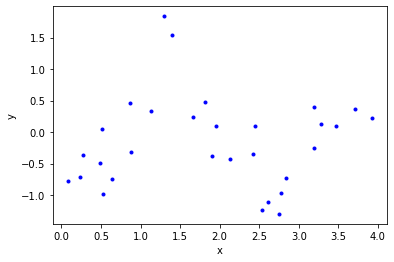

In [4]:
np.random.seed(2019*2)
X, y = gen_data(n_samples=30, x_scale=[0,4])
X_val, y_val = gen_data(n_samples=1000, x_scale=[0,4])
X_test, y_test = gen_data(n_samples=1000, x_scale=[0,4])

print(X.shape, y.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

# Plot only the training data!
plot_data(X,y)

## 1. Método do gradiente

Resgate a classe do modelo que você implementou no exercício anterior. Iremos reorganizá-la para permitir um método de treinamento alternativo.

1. Utilize a classe abaixo, substituindo na função `_fit_ne` a sua função `fit` implementada anteriormente, com as modificações necessárias. Note que a função `add_powers` foi eliminada (bem como o argumento `d` da inicialização do modelo), sendo substituída pela função `_add_ones` (que simplesmente adiciona uma coluna de 1's). Ou seja, nosso modelo deve implementar puramente uma regressão linear (com regularização L2), sem atributos adicionais. Caso desejemos atributos polinomiais, poderemos usar a classe `PolynomialFeatures` do sklearn. A única vantagem do nosso modelo de regressão próprio em relação ao `Ridge` é permitir utilizar um método de treinamento diferente.
1. Mova a função `mse` para fora da classe, caso contrário não poderemos acessá-la dentro de um `Pipeline`.

In [5]:
class Model():
    # Linear regression with L2 regularization
    def __init__(self, lamb=0, solver='ne', lr=1, maxiter=1000, tol=1e-5,dg=1):
        # Initialization
        self.lamb = lamb
        self.solver = solver
        self.lr = lr
        self.maxiter = maxiter
        self.tol = tol
        self.dg=dg
        return
    
    def _add_ones(self, X):
        # Add column of ones
        X_new = np.c_[np.ones(X.shape[0]), X]
        return X_new
# 3.1.3 -------------------------------------------------
    def _fit_ne(self, X, y): 
        d=X.shape[1]
        X = self._add_ones(X)
        L = np.zeros([d+1,d+1])
        for i in range(1,d+1):
            L[i,i]=1
        
        self.hessian = hessian(X)
        print ("np.linalg.cond(self.hessian) == \n ",np.linalg.cond(self.hessian),"\n")
        lamb = self.lamb
        assert np.linalg.matrix_rank(X.T @ X + lamb*L) == X.shape[1], 'Singular matrix'
        self.w = np.linalg.inv(np.transpose(X)@X+lamb*L)@np.transpose(X)@y
        return

# 3.1.4 -------------------------------------------------
    def _fit_gd(self, X, y,det=False): 
        # Fit by gradient descent
        
        X=self._add_ones(X)
        w=np.zeros([X.shape[1],1])
        print(w.shape)
        self.w=w
        print(X.shape[1])
        lr = self.lr*(0.1**(X.shape[1]-1))
       # print("LR  {}".format(lr))
        maxiter = self.maxiter
        tol = self.tol
        self.J_history = []
        J_history =self.J_history
        
        #
       # print("maxiter == ",maxiter)
        #print("\nrange(maxiter) == ",range(maxiter))
        #print("\nJ_history == ",J_history)
        
        for it in range(maxiter):
           # print("IT == ",it)
            grad_J = self.grad_J(X,y)

            J_history.append(np.linalg.norm(self.J(X,y)))
            w -= lr*grad_J
            self.w = w
            if det:
                if (it+1)%(maxiter/10) == 0:
                    print("\n# de iterações ==    {}".format(it+1),"\n\n",
                         "\nw == {}".format(w),"\n\n",
                         "\ngradJ == {}".format(grad_J),"\n\n",
                         "\n|gradJ| == {:.6f}".format(J_history[-1]),"\n\n",
                         "\n#J == {:.6f}".format(self.J(X,y)),"\n\n",
                         "\n---------------")
            
            if np.linalg.norm(grad_J) <tol:   
                 print("\n---------------",
                         "\nUnder tolerance","\n\n",
                         "\n # de iterações == {}".format(it+1),"\n\n",
                         "\nw == {}".format(w),"\n\n",
                         "\ngradJ == {}".format(grad_J),"\n\n",
                         "\n|gradJ| == {:.6f}".format(J_history[-1]),"\n\n",
                         "\n#J == {:.6f}".format(self.J(X,y)),"\n\n",
                         
                         "\n---------------"); break
            elif it == maxiter -1:
                print("Reached maxiter")
            self.J_history = J_history
            self.w=w
        return

    def fit(self, X, y,det=False):
        if self.solver == 'gd':
            self._fit_gd(X, y,det)
        elif self.solver == 'ne':
            self._fit_ne(X, y)
        else:
            raise RuntimeError('Unknown solver')
        return self

    def predict(self, X):
        w=self.w
        y_pred = X@w
        return y_pred
    
    def reg_J(self,X,y):
        m=1/(X.shape[0])
        w=self.w
        xawmy = ((X@w).T - y.T)
        return (m)*(np.linalg.norm(xawmy)**2+ self.lamb *np.linalg.norm(w.T)**2)
    
    def J(self,X,y):
        m=1/(X.shape[0])
        w=self.w
        xawmy = ((X@w).T - y.T).T
        return (m)*(np.linalg.norm(xawmy)**2)
    
    def grad_J(self,X,y):
        m=1/(X.shape[0])
        w=self.w
        xawmy = ((X@w).T - y.T).T
        return (2*m)*(X.T@xawmy+self.lamb*w)
    
    def hess_J(self,X,y):
        m = 1/(X.shape[0])
        lamb=self.lamb
        d= X.shape[0]
        I = np.identity(d)
        return (2*m)*(X.T@X-lamb*I)
    
# 3.1.2 -------------------------------------------------
def mse(model, X, y):
    m=X.shape[0]
    X = model._add_ones(X)
    y_pred = model.predict(X)
    y= np.reshape(y,-1)
    y_pred = np.reshape(y_pred,-1)
    J = np.sum((y_pred-y)**2)/m
    return J

def hessian(x):
    x_grad = np.gradient(x)
    hessian = np.empty((x.ndim,x.ndim)+x.shape,dtype=x.dtype)
    for k,grad_k in enumerate(x_grad):
        tmp_grad = np.gradient(grad_k)
        for l, grad_kl in enumerate (tmp_grad):
            hessian[k,l,:,:] = grad_kl
    return hessian

def grad(x):
    return np.gradient(x)

In [6]:
model = Model()
model.fit(X,y)
print('w =',model.w,'\nTrain MSE: %f'% mse(model,X,y),'\nVal MSE: %f'% mse(model,X_val,y_val))

np.linalg.cond(self.hessian) == 
  [[           inf 2.34655329e+16]
 [2.34655329e+16            inf]] 

w = [-0.20189161  0.02333163] 
Train MSE: 0.517264 
Val MSE: 0.601059


---------------- LR ==  1 ------------------


Solver ==  gd 

(2, 1)
2

--------------- 
Under tolerance 

 
 # de iterações == 197 

 
w == [[-0.2018722 ]
 [ 0.02332372]] 

 
gradJ == [[ 9.21825763e-06]
 [-3.75539546e-06]] 

 
|gradJ| == 0.517264 

 
#J == 0.517264 

 
---------------
w = [[-0.2018722 ]
 [ 0.02332372]] 

Train MSE: 0.517264 
Val MSE: 0.601058


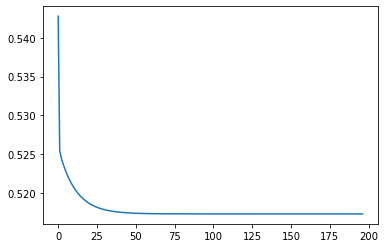

In [7]:

model = Model(solver= 'gd',lr=1,maxiter = 10000, dg=1)
#print ("---------------- LR == ",model.lr,"------------------\n")

print ("---------------- LR == ",model.lr,"------------------\n")
m_solver=model.solver

print("\nSolver == ",m_solver,"\n")
model.fit(X,y,det=True)
#_fit_gd(model,X,y)
print('w =',model.w,'\n\nTrain MSE: %f'% mse(model,X,y),'\nVal MSE: %f'% mse(model,X_val,y_val))

if m_solver == 'gd':
    plt.plot(model.J_history)
    plt.show
    
 


In [8]:
# ----------------

model = Model(solver= 'gd',lr=0.1,maxiter = 10000, dg=1)
#print ("---------------- LR == ",model.lr,"------------------\n")

print ("---------------- LR == ",model.lr,"------------------\n")
m_solver=model.solver

print("\nSolver == ",m_solver,"\n")
model.fit(X,y,det=True)
#_fit_gd(model,X,y)
print('w =',model.w,'\n\nTrain MSE: %f'% mse(model,X,y),'\nVal MSE: %f'% mse(model,X_val,y_val))


---------------- LR ==  0.1 ------------------


Solver ==  gd 

(2, 1)
2

# de iterações ==    1000 

 
w == [[-0.19996622]
 [ 0.02254725]] 

 
gradJ == [[ 0.00087709]
 [-0.00035732]] 

 
|gradJ| == 0.517265 

 
#J == 0.517265 

 
---------------

# de iterações ==    2000 

 
w == [[-0.20187116]
 [ 0.0233233 ]] 

 
gradJ == [[ 9.31428280e-06]
 [-3.79451484e-06]] 

 
|gradJ| == 0.517264 

 
#J == 0.517264 

 
---------------

--------------- 
Under tolerance 

 
 # de iterações == 2002 

 
w == [[-0.20187135]
 [ 0.02332337]] 

 
gradJ == [[ 9.22999848e-06]
 [-3.76017852e-06]] 

 
|gradJ| == 0.517264 

 
#J == 0.517264 

 
---------------
w = [[-0.20187135]
 [ 0.02332337]] 

Train MSE: 0.517264 
Val MSE: 0.601058


# ~~ Resposta - Exercício 3.1.7 --

A medida que a taxa de aprendizado é reduzida, o erro de validação tende a não se alterar, usando `lr== 0.1` obteve-se `2002` iterações e para `lr == 1` obteve-se `197` iterações. Pode-se interpretar que a taxa de aprendizado mais influi no tempo que o modelo toma para convergir do que no desempenho do modelo em si.

---------------------------------------


3. Modifique a função `_fit_ne` para calcular também a matriz hessiana da função custo (regularizada), guardando-a na variável `self.hessian`. Em seguida, após o treinamento usando a solução analítica, estime o grau de condicionamento da hessiana utilizana a função `np.linalg.cond()`.
1. Complete a função `_fit_gd` implementando o método do gradiente. Utilize os parâmetros `self.lr` (taxa de aprendizado), `self.maxiter` (número máximo de iterações) e `self.tol` (critério de parada para a norma do gradiente), e assuma como ponto inicial $\bw = (0,\ldots,0)$. Além de calcular `self.w`, sua função deve criar também uma lista, `self.J_history`, contendo os valores da função custo (regularizada) a cada iteração, a qual será usada para monitorar o treinamento e analisar a taxa de aprendizado.
1. Treine o modelo sem regularização usando `solver='gd'`, trace o gráfico de `J_history` e escolha uma boa taxa de aprendizado. Quantas iterações foram necessárias para convergência?
1. Calcule o MSE de treinamento e de validação e compare-os com os obtidos pela solução analítica. Compare também os vetores $\bw$ das duas soluções. (Obs: a saída da célula 5 está mostrada apenas para ilustração. Não é necessário reproduzir exatamente o mesmo texto/gráfico.)
1. (OPCIONAL) O que acontece com o erro de validação à medida que a taxa de aprendizado é reduzida? Como podemos interpretar esse fenômeno?

## 2. Adicionando atributos

1. Adicione atributos polinomiais de grau `d=2` usando o transformador `PolynomialFeatures`. Em seguida, repita o treinamento via solução analítica e estimação do grau de condicionamento da hessiana.
1. Repita o treinamento usando método do gradiente (incluindo gráfico da função custo) e verifique a dificuldade de convergência. Por que isso ocorre? Foi necessário alterar a taxa de aprendizado? E o número máximo de iterações?
1. Assim como anteriormente, compare o MSE e o $\bw$ obtidos com os da solução analítica.
1. Repita os itens anteriores para `d=3`.

#### Dica

- Não há necessidade de incluir o termo constante nos atributos adicionados, uma vez que o modelo de regressão linear já implementa a adição de coluna de 1's. Assim, utilize `PolynomialFeatures(d, include_bias=False)`.
- Normalmente, é conveniente utilizar a função `make_pipeline` para combinar pré-processamento (transformação de atributos) e modelo de aprendizado (estimador) em um único modelo. Além de deixar o código mais compacto, essa metodologia ajuda a evitar erros de vazamento de informação entre teste e treinamento, pois garante que o transformador será treinado somente com os dados de treinamento. No entanto, como o nosso foco aqui é o treinamento, é mais conveniente primeiramente aplicar a transformação de atributos explicitamente no conjunto de dados, obtendo um conjunto transformado (aqui com sufixo `_new`), o qual é então entregue ao modelo de aprendizado. Embora não seja o caso aqui, essa abordagem também é mais eficiente quando o pré-processamento é particularmente complexo e serão realizados múltiplos treinamentos, assim o pré-processamento só precisa ser realizado uma vez.

# ~~ Resposta - Exercício 3.2.1 --

In [9]:
# Feature transformation
d = 2
prep = PolynomialFeatures(d,include_bias=False)
X_new = prep.fit_transform(X)
X_val_new = prep.fit_transform(X_val)

# Normal equation
model = Model()
model.fit(X_new, y)
modelw=model.w
print('w == ',model.w)
print('Train MSE: %f' % mse(model,X_new,y))
print('Val MSE: %f' % mse(model,X_val_new,y_val))

np.linalg.cond(self.hessian) == 
  [[           inf 2.67140692e+16]
 [1.53694463e+16 6.06425584e+16]] 

w ==  [-0.35250239  0.26848578 -0.06441263]
Train MSE: 0.511996
Val MSE: 0.611803


In [10]:
# Gradient descent -------------------
d = 2
prep = PolynomialFeatures(d,include_bias=False)
X_new = prep.fit_transform(X)
X_val_new = prep.fit_transform(X_val)

model = Model(solver='gd',lr=1,maxiter=1000000)
model.fit(X_new, y, det = True)

print('w == ',model.w)
print('Train MSE: %f' % mse(model,X_new,y))
print('Val MSE: %f' % mse(model,X_val_new,y_val))
modelw

(3, 1)
3

--------------- 
Under tolerance 

 
 # de iterações == 8197 

 
w == [[-0.35244334]
 [ 0.26841023]
 [-0.06439475]] 

 
gradJ == [[ 6.05295019e-06]
 [-7.74432287e-06]
 [ 1.83311390e-06]] 

 
|gradJ| == 0.511996 

 
#J == 0.511996 

 
---------------
w ==  [[-0.35244334]
 [ 0.26841023]
 [-0.06439475]]
Train MSE: 0.511996
Val MSE: 0.611798


array([-0.35250239,  0.26848578, -0.06441263])

# ~~ Resposta - Exercício 3.2.2 --

Houve maior dificuldade de convergência por conta do aumento do grau do polinômio. Manteve-se o `learning rate == 1` e  o máximo de iterações precisou ser alterado para `maxiter == 1000000`, mas o modelo convergiu antes disso com `8197 iterações`. 

# ~~ Resposta - Exercício 3.2.3 --

Os valores obtidos de `w` e de `MSE` foram bem próximos da solução analítica.

 # ~~  Exercício 3.2.4 - `d == 3` --


## 3.2.4 - 1 - Solução analítica

In [11]:
# Feature transformation
d = 3
prep = PolynomialFeatures(d,include_bias=False)
X_new = prep.fit_transform(X)
X_val_new = prep.fit_transform(X_val)

# Normal equation
model = Model()
model.fit(X_new, y)
modelw=model.w
print('w == ',model.w)
print('Train MSE: %f' % mse(model,X_new,y))
print('Val MSE: %f' % mse(model,X_val_new,y_val))

np.linalg.cond(self.hessian) == 
  [[           inf 1.89013330e+16]
 [1.23998406e+16 2.77395873e+16]] 

w ==  [-1.57554215  3.91985205 -2.32464225  0.37687856]
Train MSE: 0.325498
Val MSE: 0.334947


## 3.2.4 - 2 e 3 - Método do gradiente & comparação do `MSE` e `w`

In [12]:
# Gradient descent -------------------
d = 3
print("modelw == ",modelw)
prep = PolynomialFeatures(d,include_bias=False)
X_new = prep.fit_transform(X)
X_val_new = prep.fit_transform(X_val)

# Normal equation
model = Model(solver='gd',lr=1,maxiter=1000000)
model.fit(X_new, y, det = True)

print('w == ',model.w)
print('Train MSE: %f' % mse(model,X_new,y))
print('Val MSE: %f' % mse(model,X_val_new,y_val))
modelw

modelw ==  [-1.57554215  3.91985205 -2.32464225  0.37687856]
(4, 1)
4

# de iterações ==    100000 

 
w == [[-1.26681876]
 [ 3.13032754]
 [-1.87728697]
 [ 0.30671285]] 

 
gradJ == [[ 0.00498812]
 [-0.01275654]
 [ 0.00722803]
 [-0.00113368]] 

 
|gradJ| == 0.332961 

 
#J == 0.332961 

 
---------------

# de iterações ==    200000 

 
w == [[-1.51418362]
 [ 3.76293467]
 [-2.23573074]
 [ 0.36293318]] 

 
gradJ == [[ 0.00099138]
 [-0.00253535]
 [ 0.00143657]
 [-0.00022532]] 

 
|gradJ| == 0.325793 

 
#J == 0.325793 

 
---------------

# de iterações ==    300000 

 
w == [[-1.56334719]
 [ 3.88866485]
 [-2.30697116]
 [ 0.37410692]] 

 
gradJ == [[ 1.97036971e-04]
 [-5.03899356e-04]
 [ 2.85516201e-04]
 [-4.47819594e-05]] 

 
|gradJ| == 0.325510 

 
#J == 0.325510 

 
---------------

# de iterações ==    400000 

 
w == [[-1.57311841]
 [ 3.91365362]
 [-2.32113014]
 [ 0.3763277 ]] 

 
gradJ == [[ 3.91609449e-05]
 [-1.00149606e-04]
 [ 5.67461230e-05]
 [-8.90037966e-06]] 

 
|gradJ| == 0.

array([-1.57554215,  3.91985205, -2.32464225,  0.37687856])

### Resposta  - 3.2.4 - (2 e 3) 
O número máximo de iterações teve de ser aumentado para `it == 1000000` e o modelo convergiu após um elevado número de iterações. 

#### ---- Para `lr == 1`, ----------------------------------------
O modelo convergiu, com `554776 iterações`e foi obtido um valor baixo de `MSE`. 
##### `MSE`
O modelo então converge com `Train MSE == 0.325498` e `Val MSE == 0.334952` para `554776 iterações`.

##### `w`
o valor de `w` começa a convergir para aquele obtido na solução analítica já em `400000 iterações` e já fica bem próximo quando são feitas `500000 iterações`.

#### ---- Alterando a taxa de aprendizado de `lr == 1` para `lr == 0.001` ----------------------------------------

##### `MSE`
Obteve-se `train MSE == 0,5084` e `Val MSE == 0,5680` e o modelo não convergiu quando já havia passado das `1000000 iterações`; estas previamente estipuladas em `maxiter`.
##### `w`
Os valores de `w` tornaram-se bem menores e se distanciaram do valor obtido na solução analítica

------------------------------------------------------

## 3. Escalonamento de atributos

Implemente a normalização (escalonamento) de atributos conforme vista em sala, a qual consiste de:
 - Subtração da média do atributo, para que passe a ter média nula
 - Divisão pelo desvio padrão do atributo, para que passe a ter variância unitária
 
Esse tipo de normalização também é chamado em alguns contextos de padronização (*standardization*), no sentido de resultar na mesma média (0) e variância (1) de uma variável aleatória gaussiana padrão (*standard*), em contraste com outros tipos de normalização (por exemplo, reescalonamento para a escala [0,1]).

1. Para isso, complete a classe abaixo. Caso deseje confirmar se sua implementação está correta, compare com o transformador `StandardScaler` do módulo `sklearn.preprocessing`.
1. Após implementar corretamente, verifique que seu escalonador funciona corretamente em um pipeline do `sklearn`; isto é, combine todas as etapas de pré-processamento (transformação de atributos e escalonamento) usando `make_pipeline`. Em seguida, você pode ignorar sua implementação e passar a usar o `StandardScaler`.
1. Refaça os mesmos passos da seção anterior (2.1-2.4) e compare os resultados e o comportamento do algoritmo. Explique.
1. Neste problema, em qual posição o escalonador funciona melhor, antes ou depois da adição de atributos? Cite as evidências que você observou.
1. O uso do escalonador tem impacto do desempenho da solução analítica? Por quê?
1. (OPCIONAL) Experimente outros escalonadores do `sklearn`, como `MinMaxScaler` e `MaxAbsScaler`, e compare o desempenho obtido.

#### Dicas

- Funções úteis:

```python
np.mean(axis=0), np.std(axis=0)
```

- Revise as propriedades de broadcasting do NumPy, em particular em operações envolvendo matrizes e arrays 1D.
- Para depurar possíveis erros, lembre-se de verificar o `shape` dos arrays envolvidos.

# ~~ Resposta - Exercício 3.3.1 --

In [13]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
class MyStandardScaler(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # Compute and store scaler parameters
        self.mean = np.mean(X, axis = 0)
        self.std = np.std(X, axis = 0)
        return self
    
    def transform(self, X, y=None):
        # Scale features
        X_new = X
        X_new = X_new.astype(float)
        mean = self.mean
        std = self.std
        for col in range(1,X.shape[1]):
            X_new[:,col] = (X_new[:,col] - mean[col])/std[col]
        return X_new

A = np.array([[1, 1, 1], [2, 4, 8], [3, 9, 27], [4, 16, 64]])

m = make_pipeline(MyStandardScaler())
m.fit(A)
nA = m.transform(A)
print("na (MyStandardScaler):\n",nA)

mm = make_pipeline(StandardScaler())
mm.fit(A)
nnA = m.transform(A)
print("\nnna (Standard Scaler do Sklearn):\n",nnA)

na (MyStandardScaler):
 [[ 1.         -1.14458618 -0.98184354]
 [ 2.         -0.61631563 -0.69547251]
 [ 3.          0.26413527  0.08182029]
 [ 4.          1.49676654  1.59549575]]

nna (Standard Scaler do Sklearn):
 [[ 1.         -1.14458618 -0.98184354]
 [ 2.         -0.61631563 -0.69547251]
 [ 3.          0.26413527  0.08182029]
 [ 4.          1.49676654  1.59549575]]


# ~~ Resposta - Exercício 3.3.2 --

#### * Usando MyStandardScaler() 

In [24]:
d = 2
prep = make_pipeline(MyStandardScaler(),PolynomialFeatures(d,include_bias = False))

#Feature transformation
nX = prep.fit_transform(X)
nX_val =prep.fit_transform(X_val)

m.fit(nX)
X_new = m.transform(nX)
X_val_new = m.transform(nX_val)

#Gradient Descent
model = Model(solver = 'gd',lr = 12, maxiter = 10000)
model.fit(X_new,y,det = True)

print('w = {}'.format(model.w))
print('Train MSE: %f' % mse(model,X_new,y))
print('Val MSE: %f' % mse(model,X_val_new,y_val))

(3, 1)
3

# de iterações ==    1000 

 
w == [[-0.64614041]
 [ 0.25753546]
 [-0.27486039]] 

 
gradJ == [[ 0.00059112]
 [-0.00030708]
 [ 0.00034131]] 

 
|gradJ| == 0.512006 

 
#J == 0.512006 

 
---------------

# de iterações ==    2000 

 
w == [[-0.66648724]
 [ 0.26810521]
 [-0.28660845]] 

 
gradJ == [[ 2.05437401e-05]
 [-1.06720439e-05]
 [ 1.18617571e-05]] 

 
|gradJ| == 0.511996 

 
#J == 0.511996 

 
---------------

--------------- 
Under tolerance 

 
 # de iterações == 2285 

 
w == [[-0.66693861]
 [ 0.26833969]
 [-0.28686907]] 

 
gradJ == [[ 7.88615101e-06]
 [-4.09669071e-06]
 [ 4.55338742e-06]] 

 
|gradJ| == 0.511996 

 
#J == 0.511996 

 
---------------
w = [[-0.66693861]
 [ 0.26833969]
 [-0.28686907]]
Train MSE: 0.511996
Val MSE: 0.611793


#### * Usando StandardScaler() do Sklearn

In [25]:
d = 2
prep = make_pipeline(StandardScaler(),PolynomialFeatures(d,include_bias = False))

#Feature transformation
nX = prep.fit_transform(X)
nX_val =prep.fit_transform(X_val)

m.fit(nX)
X_new = m.transform(nX)
X_val_new = m.transform(nX_val)

#Gradient Descent
model = Model(solver = 'gd',lr = 12, maxiter = 10000)
model.fit(X_new,y,det = True)

print('w = {}'.format(model.w))
print('Train MSE: %f' % mse(model,X_new,y))
print('Val MSE: %f' % mse(model,X_val_new,y_val))

(3, 1)
3

--------------- 
Under tolerance 

 
 # de iterações == 40 

 
w == [[-0.15760304]
 [ 0.02714264]
 [-0.07258721]] 

 
gradJ == [[ 7.08487370e-06]
 [-1.59131522e-06]
 [ 3.41860054e-06]] 

 
|gradJ| == 0.511996 

 
#J == 0.511996 

 
---------------
w = [[-0.15760304]
 [ 0.02714264]
 [-0.07258721]]
Train MSE: 0.511996
Val MSE: 0.610201


### ----  Apesar de os valores de `w` obtidos pelo pipeline da função personalizada terem sido diferentes, os valores de `J`, de `Train MSE` e `Val MSE` foram compatíveis com os valores obtidos pelo pipeline que usou a função `StandardScaler` do Sklearn.

# ~~ Resposta - Exercício 3.3.4 --

In [26]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, MinMaxScaler,MaxAbsScaler
from sklearn.pipeline import make_pipeline
from numpy.linalg import det

np.random.seed(2019*2)
X, y = gen_data(n_samples=30, x_scale=[0,4])
X_val, y_val = gen_data(n_samples=1000, x_scale=[0,4])
X_test, y_test = gen_data(n_samples=1000, x_scale=[0,4])




### 3.3.4 - I) -  Gradient descent - StandardScaler + PolynomialFeatures

In [27]:
# Gradient descent ------------------- Scalar + Poly

d = 2
prep = make_pipeline(StandardScaler(),PolynomialFeatures(d,include_bias = False))

#Feature transformation
nX = prep.fit_transform(X)
nX_val =prep.fit_transform(X_val)

prep.fit(nX)
X_new = prep.transform(nX)
X_val_new = prep.transform(nX_val)

model = Model(solver='gd',lr=1,maxiter=10000)
model.fit(X_new, y, det = True)

w_SP=model.w
trainMSE_SP = mse(model,X_new,y)
valMSE_SP = mse(model,X_val_new,y_val)
print('w == ',w_SP)
print('Train MSE: %f' % trainMSE_SP )
print('Val MSE: %f' % valMSE_SP )


(6, 1)
6

# de iterações ==    1000 

 
w == [[-0.00306946]
 [ 0.00045901]
 [-0.00140876]
 [-0.0043067 ]
 [ 0.00768861]
 [-0.00088344]] 

 
gradJ == [[ 0.29885936]
 [-0.03903887]
 [ 0.13721657]
 [ 0.41936948]
 [-0.75802443]
 [ 0.08101079]] 

 
|gradJ| == 0.533804 

 
#J == 0.533795 

 
---------------

# de iterações ==    2000 

 
w == [[-0.00598049]
 [ 0.00078253]
 [-0.00274632]
 [-0.00839244]
 [ 0.01516219]
 [-0.00162501]] 

 
gradJ == [[ 0.28352871]
 [-0.02577028]
 [ 0.13040108]
 [ 0.39805315]
 [-0.7368086 ]
 [ 0.06755041]] 

 
|gradJ| == 0.525456 

 
#J == 0.525448 

 
---------------

# de iterações ==    3000 

 
w == [[-0.00874308]
 [ 0.00097613]
 [-0.00401859]
 [-0.0122724 ]
 [ 0.02242651]
 [-0.0022388 ]] 

 
gradJ == [[ 0.26915802]
 [-0.0130537 ]
 [ 0.12414837]
 [ 0.37819103]
 [-0.71617194]
 [ 0.05543141]] 

 
|gradJ| == 0.517705 

 
#J == 0.517698 

 
---------------

# de iterações ==    4000 

 
w == [[-0.01136647]
 [ 0.00104527]
 [-0.00523094]
 [-0.01596053]
 [ 0.02948736

### 3.3.4 - II) - Gradient descent - PolynomialFeatures + StandardScaler

In [28]:
# Gradient descent ------------------- Poly + Scalar


d = 2
prep = make_pipeline(StandardScaler(),PolynomialFeatures(d,include_bias = False))

#Feature transformation
nX = prep.fit_transform(X)
nX_val =prep.fit_transform(X_val)

prep.fit(nX)
X_new = prep.transform(nX)
X_val_new = prep.transform(nX_val)

model = Model(solver='gd',lr=1,maxiter=10000)
model.fit(X_new, y, det = True)

w_PS=model.w
trainMSE_PS = mse(model,X_new,y)
valMSE_PS = mse(model,X_val_new,y_val)

print('w_P-S == ',w_PS)
print('\nw_S-P == ',w_SP)

print('Train MSE P-S: %f' % trainMSE_PS )
print('Train MSE S-P: %f' % trainMSE_SP )

print('Val MSE P-S: %f' % valMSE_PS )
print('Val MSE S-P: %f' % valMSE_SP )







(6, 1)
6

# de iterações ==    1000 

 
w == [[-0.00306946]
 [ 0.00045901]
 [-0.00140876]
 [-0.0043067 ]
 [ 0.00768861]
 [-0.00088344]] 

 
gradJ == [[ 0.29885936]
 [-0.03903887]
 [ 0.13721657]
 [ 0.41936948]
 [-0.75802443]
 [ 0.08101079]] 

 
|gradJ| == 0.533804 

 
#J == 0.533795 

 
---------------

# de iterações ==    2000 

 
w == [[-0.00598049]
 [ 0.00078253]
 [-0.00274632]
 [-0.00839244]
 [ 0.01516219]
 [-0.00162501]] 

 
gradJ == [[ 0.28352871]
 [-0.02577028]
 [ 0.13040108]
 [ 0.39805315]
 [-0.7368086 ]
 [ 0.06755041]] 

 
|gradJ| == 0.525456 

 
#J == 0.525448 

 
---------------

# de iterações ==    3000 

 
w == [[-0.00874308]
 [ 0.00097613]
 [-0.00401859]
 [-0.0122724 ]
 [ 0.02242651]
 [-0.0022388 ]] 

 
gradJ == [[ 0.26915802]
 [-0.0130537 ]
 [ 0.12414837]
 [ 0.37819103]
 [-0.71617194]
 [ 0.05543141]] 

 
|gradJ| == 0.517705 

 
#J == 0.517698 

 
---------------

# de iterações ==    4000 

 
w == [[-0.01136647]
 [ 0.00104527]
 [-0.00523094]
 [-0.01596053]
 [ 0.02948736

### 3.3.4 Resposta: 

Como observado, na realidade, ao menos para este problema, não houve diferneça entre adicionar o escalonador antes ou depois da adição dos atributos. Pôde-se constatar este fato pela comparação das variáveis de `MSE`,`w`, `Número de iterações` e `J`, que foram iguais

# ~~ Resposta - Exercício 3.3.6 --

### Gradient descent ------------------- MinMaxScaler

In [29]:
d = 2
prep = make_pipeline(MinMaxScaler(),PolynomialFeatures(d,include_bias = False))

#Feature transformation
nX = prep.fit_transform(X)
nX_val =prep.fit_transform(X_val)

prep.fit(nX)
X_new = prep.transform(nX)
X_val_new = prep.transform(nX_val)

#Gradient Descent
model = Model(solver = 'gd',lr = 12, maxiter = 10000)
model.fit(X_new,y,det = True)

w_MM=model.w
trainMSE_MM = mse(model,X_new,y)
valMSE_MM = mse(model,X_val_new,y_val)


(6, 1)
6

# de iterações ==    1000 

 
w == [[-0.03203845]
 [-0.01286845]
 [-0.00908677]
 [-0.00908677]
 [-0.00531395]
 [-0.00219911]] 

 
gradJ == [[0.22454345]
 [0.08430777]
 [0.05968184]
 [0.05968184]
 [0.03195659]
 [0.0083374 ]] 

 
|gradJ| == 0.531085 

 
#J == 0.531077 

 
---------------

# de iterações ==    2000 

 
w == [[-0.0550298 ]
 [-0.02087525]
 [-0.01478114]
 [-0.01478114]
 [-0.00802555]
 [-0.00229213]] 

 
gradJ == [[ 0.1626269 ]
 [ 0.05137382]
 [ 0.03681668]
 [ 0.03681668]
 [ 0.01447473]
 [-0.00577511]] 

 
|gradJ| == 0.525477 

 
#J == 0.525473 

 
---------------

# de iterações ==    3000 

 
w == [[-0.07183906]
 [-0.02563038]
 [-0.01823065]
 [-0.01823065]
 [-0.00902724]
 [-0.00100873]] 

 
gradJ == [[ 0.12022019]
 [ 0.02938395]
 [ 0.02174568]
 [ 0.02174568]
 [ 0.00305144]
 [-0.01493579]] 

 
|gradJ| == 0.522683 

 
#J == 0.522681 

 
---------------

# de iterações ==    4000 

 
w == [[-0.08440361]
 [-0.02821851]
 [-0.02020707]
 [-0.02020707]
 [-0.00891861]
 [ 0

### Gradient descent ------------------- MaxAbsScaler

In [30]:
# Gradient descent ------------------- MinMaxScaler

d = 2
prep = make_pipeline(MinMaxScaler(),PolynomialFeatures(d,include_bias = False))

#Feature transformation
nX = prep.fit_transform(X)
nX_val =prep.fit_transform(X_val)

prep.fit(nX)
X_new = prep.transform(nX)
X_val_new = prep.transform(nX_val)

model = Model(solver='gd',lr=1,maxiter=10000)
model.fit(X_new, y, det = True)

w_MA=model.w
trainMSE_MA = mse(model,X_new,y)
valMSE_MA = mse(model,X_val_new,y_val)

print('w_MA == ',w_MA)
print('\nw_MM == ',w_MM)

print('Train MSE MA: %f' % trainMSE_MA )
print('Train MSE MM: %f' % trainMSE_MM )

print('Val MSE MA: %f' % valMSE_MA )
print('Val MSE MM: %f' % valMSE_MM )

(6, 1)
6

# de iterações ==    1000 

 
w == [[-0.0031071 ]
 [-0.00130969]
 [-0.00092364]
 [-0.00092364]
 [-0.00057089]
 [-0.00028715]] 

 
gradJ == [[0.30625707]
 [0.12854211]
 [0.09065855]
 [0.09065855]
 [0.05577505]
 [0.0276478 ]] 

 
|gradJ| == 0.541455 

 
#J == 0.541454 

 
---------------

# de iterações ==    2000 

 
w == [[-0.006126  ]
 [-0.00257133]
 [-0.00181352]
 [-0.00181352]
 [-0.00111577]
 [-0.00055318]] 

 
gradJ == [[0.29757683]
 [0.12381561]
 [0.08733929]
 [0.08733929]
 [0.05321812]
 [0.02557196]] 

 
|gradJ| == 0.540189 

 
#J == 0.540188 

 
---------------

# de iterações ==    3000 

 
w == [[-0.00905947]
 [-0.00378647]
 [-0.00267076]
 [-0.00267076]
 [-0.00163551]
 [-0.0007988 ]] 

 
gradJ == [[0.28917074]
 [0.11924368]
 [0.08413036]
 [0.08413036]
 [0.05074707]
 [0.02356638]] 

 
|gradJ| == 0.539001 

 
#J == 0.539000 

 
---------------

# de iterações ==    4000 

 
w == [[-0.01191021]
 [-0.00495665]
 [-0.00349645]
 [-0.00349645]
 [-0.00213097]
 [-0.00102471]] 

### Resposta 3.3.6 - 

Substituindo o escalonador padrão tanto pelo `MinMaxScaler` como pelo `MaxAbsScaler`, observa-se um crescimento tanto nos valores de `MSE` como nas funções custo (`J`). Sendo que o `MinMaxScaler` obteve um desempenho levemente superior ao `MaxAbsScaler`, mas ambos ficaram bem distantes do `StandardScaler`.

## 4. Ainda mais atributos

1. Adicione atributos polinomiais de grau ainda maior (ex: d=4, d=5). O que você observa?
1. Você recomendaria o método do gradiente para um problema desse tipo? Ou seria melhor usar um método de segunda ordem? Explique.

# ~~ Resposta - Exercício 3.4.1 --

#### Resultado para d == 3

#J == 0.476219 

 
---------------
Reached maxiter

w_S-P ==  [[-0.02462087]
 [-0.00086611]
 [-0.01149158]
 [-0.03471332]
 [ 0.06790173]
 [-0.00389155]]
 

Train MSE S-P: 0.476219

Val MSE S-P: 0.530108


### d == 4

In [43]:


d = 4
print("d == ",d,"\n")
prep = make_pipeline(StandardScaler(),PolynomialFeatures(d,include_bias = False))

#Feature transformation
nX = prep.fit_transform(X)
nX_val =prep.fit_transform(X_val)

prep.fit(nX)
X_new = prep.transform(nX)
X_val_new = prep.transform(nX_val)

model = Model(solver='gd',lr=1,maxiter=10000)
model.fit(X_new, y, det = True)

w=model.w
trainMSE = mse(model,X_new,y)
valMSE= mse(model,X_val_new,y_val)

# print('w == ',w)

print('Train MSE: %f' % trainMSE )

print('Val MSE: %f' % valMSE )


d ==  4 

(70, 1)
70

# de iterações ==    1000 

 
w == [[-3.15211471e-67]
 [ 5.28585197e-68]
 [-1.44643046e-67]
 [ 3.79126141e-67]
 [-3.45768204e-68]
 [-4.42243877e-67]
 [ 7.79793459e-67]
 [-3.29611246e-67]
 [ 7.27803087e-67]
 [-9.59366930e-68]
 [ 6.67427017e-67]
 [-6.63839378e-68]
 [-2.68540497e-67]
 [ 6.68559089e-67]
 [-4.04599413e-68]
 [ 7.37710245e-67]
 [-2.28899215e-67]
 [ 9.65292310e-67]
 [-9.28783538e-68]
 [ 5.94868502e-67]
 [-2.18131108e-67]
 [ 6.57666442e-67]
 [ 1.18619597e-66]
 [-8.54680755e-68]
 [ 7.70679615e-67]
 [-1.37580202e-67]
 [ 9.88352081e-67]
 [-1.22542777e-68]
 [-1.61885389e-67]
 [ 1.09453487e-66]
 [ 1.31532236e-67]
 [ 1.50027751e-66]
 [-7.08503546e-70]
 [ 1.26741628e-66]
 [ 3.14450337e-67]
 [-6.43274061e-67]
 [ 1.30223529e-66]
 [-5.21184366e-67]
 [ 1.30539705e-66]
 [-2.16766174e-67]
 [ 1.53544485e-66]
 [-7.71462277e-68]
 [-4.10715950e-67]
 [ 1.62983170e-66]
 [ 7.50579275e-68]
 [ 1.51956480e-66]
 [-1.05056142e-67]
 [ 1.68447540e-66]
 [ 1.98295543e-66]
 [ 1.0231723

### d == 5

In [41]:

d = 5
print("d == ",d,"\n")
prep = make_pipeline(StandardScaler(),PolynomialFeatures(d,include_bias = False))

#Feature transformation
nX = prep.fit_transform(X)
nX_val =prep.fit_transform(X_val)

prep.fit(nX)
X_new = prep.transform(nX)
X_val_new = prep.transform(nX_val)

model = Model(solver='gd',lr=1,maxiter=10000)
model.fit(X_new, y, det = True)

w=model.w
trainMSE = mse(model,X_new,y)
valMSE= mse(model,X_val_new,y_val)

# print('w == ',w)

print('Train MSE: %f' % trainMSE )

print('Val MSE: %f' % valMSE )


d ==  5 

(252, 1)
252

# de iterações ==    1000 

 
w == [[-3.15211471e-249]
 [ 5.28585197e-250]
 [-1.44643046e-249]
 [ 3.79126141e-249]
 [-3.45768204e-250]
 [ 4.01534258e-249]
 [-4.42243877e-249]
 [ 7.79793459e-249]
 [-3.29611246e-249]
 [ 7.27803087e-249]
 [-2.10362096e-249]
 [-9.59366930e-250]
 [ 6.67427017e-249]
 [-6.63839378e-250]
 [ 6.22668815e-249]
 [-2.68540497e-249]
 [ 6.68559089e-249]
 [-1.81056206e-249]
 [-4.04599413e-250]
 [ 6.55584931e-249]
 [-1.10884900e-249]
 [ 7.37710245e-249]
 [-2.28899215e-249]
 [ 9.65292310e-249]
 [-9.28783538e-250]
 [ 9.48391644e-249]
 [ 5.94868502e-249]
 [-2.18131108e-249]
 [ 6.57666442e-249]
 [-1.59148619e-249]
 [ 1.18619597e-248]
 [-8.54680755e-250]
 [ 1.18967380e-248]
 [ 7.70679615e-249]
 [-3.03470894e-250]
 [ 1.22786842e-248]
 [-1.37580202e-249]
 [ 9.88352081e-249]
 [-1.22542777e-250]
 [ 1.07136810e-248]
 [-1.61885389e-249]
 [ 1.09453487e-248]
 [-5.93235003e-250]
 [ 1.31532236e-249]
 [ 1.22206311e-248]
 [ 6.42676881e-250]
 [ 1.50027751e-248]
 

# de iterações ==    2000 

 
w == [[-6.30422942e-249]
 [ 1.05717039e-249]
 [-2.89286092e-249]
 [ 7.58252282e-249]
 [-6.91536409e-250]
 [ 8.03068516e-249]
 [-8.84487754e-249]
 [ 1.55958692e-248]
 [-6.59222492e-249]
 [ 1.45560617e-248]
 [-4.20724191e-249]
 [-1.91873386e-249]
 [ 1.33485403e-248]
 [-1.32767876e-249]
 [ 1.24533763e-248]
 [-5.37080995e-249]
 [ 1.33711818e-248]
 [-3.62112412e-249]
 [-8.09198827e-250]
 [ 1.31116986e-248]
 [-2.21769799e-249]
 [ 1.47542049e-248]
 [-4.57798431e-249]
 [ 1.93058462e-248]
 [-1.85756708e-249]
 [ 1.89678329e-248]
 [ 1.18973700e-248]
 [-4.36262216e-249]
 [ 1.31533288e-248]
 [-3.18297238e-249]
 [ 2.37239194e-248]
 [-1.70936151e-249]
 [ 2.37934761e-248]
 [ 1.54135923e-248]
 [-6.06941788e-250]
 [ 2.45573685e-248]
 [-2.75160404e-249]
 [ 1.97670416e-248]
 [-2.45085555e-250]
 [ 2.14273620e-248]
 [-3.23770779e-249]
 [ 2.18906975e-248]
 [-1.18647001e-249]
 [ 2.63064471e-249]
 [ 2.44412623e-248]
 [ 1.28535376e-249]
 [ 3.00055502e-248]
 [-1.41700709e-251]
 [ 3.


# de iterações ==    4000 

 
w == [[-1.26084588e-248]
 [ 2.11434079e-249]
 [-5.78572184e-249]
 [ 1.51650456e-248]
 [-1.38307282e-249]
 [ 1.60613703e-248]
 [-1.76897551e-248]
 [ 3.11917384e-248]
 [-1.31844498e-248]
 [ 2.91121235e-248]
 [-8.41448383e-249]
 [-3.83746772e-249]
 [ 2.66970807e-248]
 [-2.65535751e-249]
 [ 2.49067526e-248]
 [-1.07416199e-248]
 [ 2.67423635e-248]
 [-7.24224824e-249]
 [-1.61839765e-249]
 [ 2.62233972e-248]
 [-4.43539599e-249]
 [ 2.95084098e-248]
 [-9.15596861e-249]
 [ 3.86116924e-248]
 [-3.71513415e-249]
 [ 3.79356658e-248]
 [ 2.37947401e-248]
 [-8.72524431e-249]
 [ 2.63066577e-248]
 [-6.36594476e-249]
 [ 4.74478388e-248]
 [-3.41872302e-249]
 [ 4.75869521e-248]
 [ 3.08271846e-248]
 [-1.21388358e-249]
 [ 4.91147370e-248]
 [-5.50320807e-249]
 [ 3.95340832e-248]
 [-4.90171110e-250]
 [ 4.28547239e-248]
 [-6.47541557e-249]
 [ 4.37813950e-248]
 [-2.37294001e-249]
 [ 5.26128942e-249]
 [ 4.88825245e-248]
 [ 2.57070752e-249]
 [ 6.00111004e-248]
 [-2.83401418e-251]
 [ 6


# de iterações ==    7000 

 
w == [[-2.20648030e-248]
 [ 3.70009638e-249]
 [-1.01250132e-248]
 [ 2.65388299e-248]
 [-2.42037743e-249]
 [ 2.81073981e-248]
 [-3.09570714e-248]
 [ 5.45855421e-248]
 [-2.30727872e-248]
 [ 5.09462161e-248]
 [-1.47253467e-248]
 [-6.71556851e-249]
 [ 4.67198912e-248]
 [-4.64687565e-249]
 [ 4.35868171e-248]
 [-1.87978348e-248]
 [ 4.67991362e-248]
 [-1.26739344e-248]
 [-2.83219589e-249]
 [ 4.58909452e-248]
 [-7.76194298e-249]
 [ 5.16397172e-248]
 [-1.60229451e-248]
 [ 6.75704617e-248]
 [-6.50148476e-249]
 [ 6.63874151e-248]
 [ 4.16407951e-248]
 [-1.52691775e-248]
 [ 4.60366509e-248]
 [-1.11404033e-248]
 [ 8.30337179e-248]
 [-5.98276529e-249]
 [ 8.32771662e-248]
 [ 5.39475731e-248]
 [-2.12429626e-249]
 [ 8.59507897e-248]
 [-9.63061413e-249]
 [ 6.91846457e-248]
 [-8.57799442e-250]
 [ 7.49957669e-248]
 [-1.13319773e-248]
 [ 7.66174412e-248]
 [-4.15264502e-249]
 [ 9.20725649e-249]
 [ 8.55444179e-248]
 [ 4.49873817e-249]
 [ 1.05019426e-247]
 [-4.95952482e-251]
 [ 1


# de iterações ==    9000 

 
w == [[-2.83690324e-248]
 [ 4.75726677e-249]
 [-1.30178741e-248]
 [ 3.41213527e-248]
 [-3.11191384e-249]
 [ 3.61380832e-248]
 [-3.98019489e-248]
 [ 7.01814113e-248]
 [-2.96650122e-248]
 [ 6.55022778e-248]
 [-1.89325886e-248]
 [-8.63430237e-249]
 [ 6.00684316e-248]
 [-5.97455440e-249]
 [ 5.60401934e-248]
 [-2.41686448e-248]
 [ 6.01703180e-248]
 [-1.62950585e-248]
 [-3.64139472e-249]
 [ 5.90026438e-248]
 [-9.97964097e-249]
 [ 6.63939221e-248]
 [-2.06009294e-248]
 [ 8.68763079e-248]
 [-8.35905184e-249]
 [ 8.53552480e-248]
 [ 5.35381652e-248]
 [-1.96317997e-248]
 [ 5.91899798e-248]
 [-1.43233757e-248]
 [ 1.06757637e-247]
 [-7.69212680e-249]
 [ 1.07070642e-247]
 [ 6.93611654e-248]
 [-2.73123804e-249]
 [ 1.10508158e-247]
 [-1.23822182e-248]
 [ 8.89516873e-248]
 [-1.10288500e-249]
 [ 9.64231289e-248]
 [-1.45696850e-248]
 [ 9.85081387e-248]
 [-5.33911502e-249]
 [ 1.18379012e-248]
 [ 1.09985680e-247]
 [ 5.78409193e-249]
 [ 1.35024976e-247]
 [-6.37653192e-251]
 [ 1

Resposta: Observa-se uma piora no desempenho do modelo(tanto para `J` como para os valores de `MSE` ) a medida que o valor de `d` aumenta, tanto para `d == 4` como para `d == 5`.

# ~~ Resposta - Exercício 3.4.2 --

Não parece ser recomendável o uso do método gradiente para problemas deste tipo, já que mesmo para graus pequenos o modelo já chegou a não convergir. Além disso, a medida que `d` aumenta, o modelo não apresenta, concomitantemente, uma melhora de desempenho que justifique o uso desta técnica.

# 5. Conjunto de dados #2

O segundo conjunto de dados que usaremos consiste de dados sobre a venda de casas em King County, USA, entre maio de 2014 e maio de 2015. O objetivo é prever o preço de venda a partir de informações sobre a casa. 

In [187]:
import pandas as pd
# Original source: http://www.kaggle.com/harlfoxem/housesalesprediction/data
df = pd.read_csv('https://github.com/danilo-silva-ufsc/ml/raw/master/data/kc_house_data.csv')
print(df.shape)
df.head()

(21613, 21)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


Como variável de saída, $y$, utilize o **logaritmo** neperiano do preço de venda , `price`, i.e., `np.log(price)`. Desta forma o erro na predição de $y$ será função do erro _relativo_ na predição do preço, evitando dar peso excessivo aos preços mais altos. Por exemplo, quando a função perda é o erro quadrático, a perda equivale aproximadamente ao quadrado do erro relativo:

$L(y,\hat{y}) = (\hat{y} - y)^2 = (\log(\hat{p}) - \log(p))^2 = (\log(\hat{p}/p))^2 = (\log(1 + (\hat{p}-p)/p))^2 \approx ((\hat{p}-p)/p)^2$


Como atributos, utilize apenas as 4 colunas após o preço de venda, i.e.:
- `bedrooms`: número de quartos
- `bathrooms`: número de quartos, em múltiplos de 1/4 (https://www.realtor.com/advice/buy/what-is-a-half-bath/)
- `sqft_living`: área da casa, em ft${^2}$
- `sqft_lot`: área do lote, em ft${^2}$

## Preparação

1. Prepare e divida o conjunto de dados aleatoriamente em conjuntos de treinamento, validação e teste, nas proporções 60%, 20% e 20%, respectivamente. Para isso, utilize a função `sklearn.model_selection.train_test_split()`.
1. Como função perda para o treinamento, utilize o erro quadrático, e, como métrica de avaliação do modelo, utilize a raiz quadrada do erro quadrático médio. Ambos são equivalentes, mas o segundo resulta em valores numa escala mais agradável para análise e mais fácil de interpretar. Adicionalmente, utilize como métrica de avaliação o [erro percentual absoluto médio](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error) (MAPE) do preço de venda (i.e., da variável original `price`, **não** da variável `y = np.log(price)`). Esta métrica é ainda mais fácil de interpretar.

In [188]:
# Removing outliers
df = df[df['bedrooms'] < 10]
df = df[df['bathrooms'] < 6]
df = df[df['sqft_living'] < 7000]
df = df[df['sqft_lot'] < 600e3]

tags = ['bedrooms','bathrooms','sqft_living','sqft_lot']

X = df[['bedrooms','bathrooms','sqft_living','sqft_lot']].to_numpy()
y = df[['price']].to_numpy()
#oy=y
y = np.log10(y)
print(X.shape, y.shape)


(21560, 4) (21560, 1)


# ~~ Resposta - Exercício 3.5.1 --


In [189]:
from sklearn.model_selection import train_test_split

X_train, X_ntrain, y_train, y_ntrain = train_test_split(X, y, test_size=0.4, random_state=0)
X_test, X_val, y_test, y_val = train_test_split(X_ntrain,y_ntrain,test_size = 0.5, random_state=0)
del(X,y) # just to make sure we will not use them by mistake. Or set X,y = X_train,y_train

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(12936, 4) (12936, 1)
(4312, 4) (4312, 1)
(4312, 4) (4312, 1)


# ~~ Resposta - Exercício 3.5.2 --


In [190]:
def mse(model,X,y):
    m = X.shape[0]
    X = model._add_ones(X)
    y_pred = model.predict(X)
    y = np.reshape(y, -1)
    y_pred = np.reshape(y_pred,-1)
    J = np.sum((y_pred - y)**2 )/m
    return J

def rmse(model, X, y):
    m = X.shape[0]
    X = model._add_ones(X)
    y_pred = model.predict(X)
    y = np.reshape(y,-1)
    y_pred = np.reshape(y_pred,-1)
    J = np.sum((y_pred - y)**2)/m
    J = np.sqrt(J)
    return J

In [191]:
def mape(model, X, y):
    m = X.shape[0]
    X = model._add_ones(X)
    y_pred = model.predict(X)
    y = np.reshape(y,-1)
    y_pred = np.reshape(y_pred,-1)
    J = np.sum(np.abs((10**y_pred - 10**y)/10**y))/m
    return J

## Exploração dos dados

Antes de escolher e começar a treinar um modelo, é útil fazer uma breve exploração dos dados. (Foi dessa exploração inicial que surgiu a ideia, por exemplo, de remover outliers, com aqueles valores específicos.) 

3. Para cada atributo, trace o gráfico da variável de saída em função do atributo, **sobre o conjunto de treinamento** (não trace gráficos sobre o conjunto de teste para evitar vazamento de informação). Observe as escalas das variáveis envolvidas e analise se há alguma dependência aparente entre as variáveis. Intuitivamente, qual atributo parece ser mais preditivo do preço do venda?

# ~~ Resposta - Exercício 3.5.3 --


In [192]:
X_train.shape

(12936, 4)

np.linalg.cond(self.hessian) == 
  [[           inf 4.00790554e+15]
 [4.00790554e+15 1.15798555e+16]] 

y_pred.shape ==  (12936, 1)


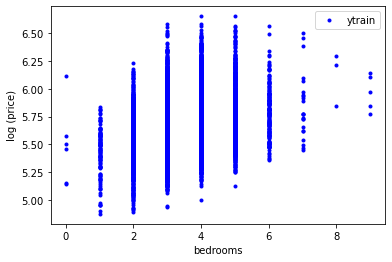

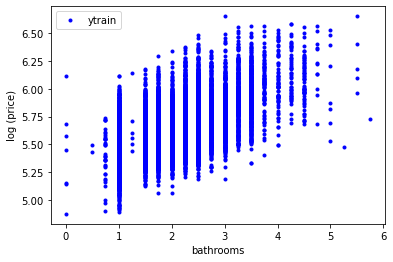

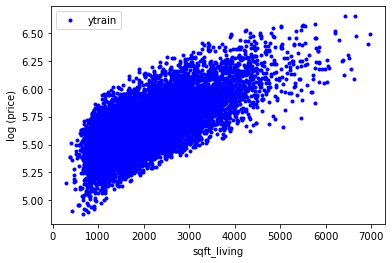

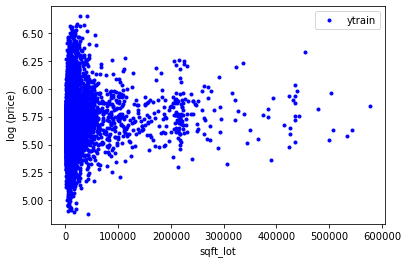

In [193]:
from sklearn.linear_model import LinearRegression

model = Model()
model.fit(X_train,y_train)
#y_pred = model.predict(X_train)
print("y_pred.shape == ",y_pred.shape)

import matplotlib.pyplot as plt 
for col in range(X_train.shape[1]):
    plt.plot(X_train[:,col], y_train,'b.', label = 'ytrain')
    #plt.plot(X_train[:,col], y_pred,'r.', label = 'ypred')
    
    plt.legend(['ytrain'])
    
    plt.xlabel(tags[col])
    plt.ylabel("log (price)")
    
    plt.show()


In [194]:
X_train.shape

(12936, 4)

### Resposta 3.5.3
O atributo que parece ser o mais preditivo do preço da venda é o `sqft_living`.

## Regressão linear

4. Inicialmente você deve treinar um modelo de regressão linear sem regularização e calcular o desempenho da predição (RMSE e MAPE) sobre o conjunto de treinamento e sobre o conjunto de validação. Fique à vontade para usar as funções do `sklearn`, não há necessidade de usar o método do gradiente.
1. Você diria que o modelo treinado sofre de underfitting, overfitting ou nenhum dos dois? Explique.
1. Analisando o vetor de pesos do modelo treinado (`model.coef_`), qual atributo você diria que é o mais importante para a predição? Por quê? Esta observação confirma a sua hipótese do item anterior? Explique.

#### Dica
- Para acessar o regressor dentro de um *pipeline* do sklearn, inicialize-o fora do *pipeline* ou acesse-o via `model.steps[-1][1]`.

# ~~ Resposta - Exercício 3.5.4 --


In [205]:
model = Model()
model.fit(X_train,y_train)

tMSE_ant = mse(model,X_train,y_train)
tRMSE_ant = rmse(model,X_train,y_train)
tMAPE_ant = mape(model,X_train,y_train)

vMSE_ant = mse(model,X_val,y_val)
vRMSE_ant = rmse(model,X_val,y_val)
vMAPE_ant = mape(model,X_val,y_val)


print('*  w = ',model.w,'\n')
print('*  Train MSE: %f' % tMSE_ant)
print('*  Train RMSE: %f' % tRMSE_ant)
print('*  Train MAPE: %f' % tMAPE_ant ,"\n")

print('*  Val MSE: %f' % vMSE_ant)
print('*  Val RMSE: %f' % vRMSE_ant)
print('*  Val MAPE: %f' % vMAPE_ant)

np.linalg.cond(self.hessian) == 
  [[           inf 4.00790554e+15]
 [4.00790554e+15 1.15798555e+16]] 

*  w =  [[ 5.34551773e+00]
 [-3.11833465e-02]
 [ 2.35412166e-02]
 [ 1.82556049e-04]
 [-1.97389852e-07]] 

*  Train MSE: 0.026397
*  Train RMSE: 0.162472
*  Train MAPE: 0.317079 

*  Val MSE: 0.026419
*  Val RMSE: 0.162539
*  Val MAPE: 0.315482


# ~~ Resposta - Exercício 3.5.5 --

y_pred.shape ==  (12936, 1)


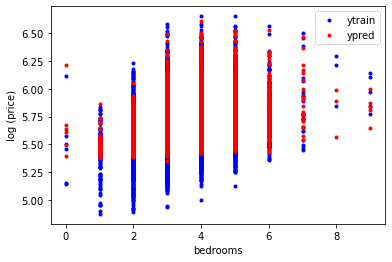

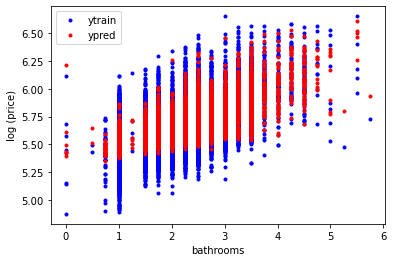

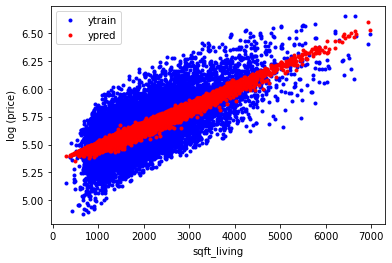

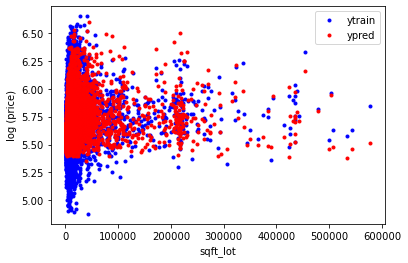

In [196]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train,y_train)
y_pred = model.predict(X_train)
print("y_pred.shape == ",y_pred.shape)




import matplotlib.pyplot as plt 
for col in range(X_train.shape[1]):
    plt.plot(X_train[:,col], y_train,'b.', label = 'ytrain')
    plt.plot(X_train[:,col], y_pred,'r.', label = 'ypred')
    
    plt.legend(['ytrain','ypred'])
    
    plt.xlabel(tags[col])
    plt.ylabel("log (price)")
    
    plt.show()

### Resposta - 3.5.5 :

O modelo parece ter se ajustado bem aos dados, não parece sofrer nem de overfitting nem underfitting. As curvas de treino e predição possuem comportamentos semelhantes (não sofrem portanto de underfitting), porém ainda possuem uma diferença considerável entre sipermitindo uma abrangência maior de predição caso novas amostras tenham uma variação de comportamento similar (não sofrem portanto de overfitting).

# ~~ Resposta - Exercício 3.5.6 --

In [197]:
print("\nmodel.coef_ == ",model.coef_)


model.coef_ ==  [[-3.11833465e-02  2.35412166e-02  1.82556049e-04 -1.97389852e-07]]


### Resposta 3.5.6 : 
O atributo mais importante para a predição é o `bedrooms`, pois este, devido à sua magnitude, influencia mais (em módulo) no preço dos imóveis do que os demais atributos. A afirmação rejeita a hipótese anterior de que a variável de maior influência seria `sqft_living`, isso porque o critério intuitivo anterior (análise visual dos gráficos) não tomava em consideração a influência analítica dos pesos no preço resultante dos imóveis. O peso do modelo já treinado apresentam-se, portanto, um critério mais preciso do que a análise visual, sujeita a erros por questão de distribuição das amostras e escalas dos gráficos.

## Aprimorando o modelo

7. Usando o que vimos até agora na disciplina, tente ao máximo melhorar o desempenho do modelo neste conjunto de dados. Reporte o desempenho obtido (RMSE e MAPE).

#### Dica:
- Reveja os conceitos aprendidos na Aula 2 e no Exercício 2.
- Se desejar aplicar alguma transformação de atributos "customizada", você tem duas opções: criar um transformador customizado do `sklearn` e integrá-lo em uma *pipeline* (ver último item opcional do Exercício 2), ou, *somente se for uma transformação que não envolve estimação de parâmetros*, você pode aplicá-la diretamente a todo o conjunto de dados (matrix $\bX$ antes do *split*).

# ~~ Resposta - Exercício 3.5.7 --

In [208]:
m = make_pipeline(StandardScaler())

d = 2
prep = PolynomialFeatures(d,include_bias = False)
nX_train = prep.fit_transform(X_train)
nX_val = prep.fit_transform(X_val)

m.fit(nX_train)
Xn_train = m.transform(nX_train)
Xn_val = m.transform(nX_val)

model = Model()

model.fit(Xn_train,y_train)

#print('w = ',model.w)



#print('*  w = ',model.w,'\n')
print("---- Modelo anterior--------------------------------------\n")

print('*  Train RMSE_ant: %f' % tRMSE_ant)
print('*  Train MAPE_ant: %f' % tMAPE_ant ,"\n")


print('*  Val RMSE_ant: %f' % vRMSE_ant)
print('*  Val MAPE_ant: %f' % vMAPE_ant)
print("---- Modelo aprimorado--------------------------------------\n")

#print('*  Train MSE: %f' % mse(model,X_train,y_train))
print('*  Train RMSE: %f' % rmse(model,Xn_train,y_train))
print('*  Train MAPE: %f' % mape(model,Xn_train,y_train),"\n")

#print('*  Val MSE: %f' % mse(model,X_val,y_val))
print('*  Val RMSE: %f' % rmse(model,Xn_val,y_val))
print('*  Val MAPE: %f' % mape(model,Xn_val,y_val))

np.linalg.cond(self.hessian) == 
  [[           inf 9.21456149e+15]
 [1.06556365e+16 1.26536877e+16]] 

---- Modelo anterior--------------------------------------

*  Train RMSE_ant: 0.162472
*  Train MAPE_ant: 0.317079 

*  Val RMSE_ant: 0.162539
*  Val MAPE_ant: 0.315482
---- Modelo aprimorado--------------------------------------

*  Train RMSE: 0.161600
*  Train MAPE: 0.315081 

*  Val RMSE: 0.161202
*  Val MAPE: 0.312282


### Resposta 3.5.7 : 
O modelo aprimorado obteve um desempenho levemente melhor do que o modleo anterior tanto no `RMSE` como no `MAPE` de validação.

## (OPCIONAL)

- Tente utilizar mais colunas da tabela original para melhorar o desempenho.
- Utilize um outro conjunto de dados com múltiplos atributos. Sugestão: https://archive.ics.uci.edu/ml/datasets/Wine+Quality